In [312]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from highlight_text.htext import htext, fig_htext

import importing_sb as imsb
import draw_pitch as dp

%matplotlib inline

In [3]:
data_dir = 'data/open-data/data/'

In [4]:
comp_data = imsb.open_data(data_dir + 'competitions.json')

In [ ]:
# comp_id = 11 is La Liga, season_id = 4 is 18/19

In [14]:
match_data = sorted(imsb.open_data(data_dir + 'matches/11/4.json'), key = lambda x: x['match_date'])

In [25]:
event_data = []
lineup_data =[]
for match in match_data:
    event_data.append(imsb.open_data(data_dir + 'events/{}.json'.format(match['match_id'])))
    lineup_data.append(imsb.open_data(data_dir + 'lineups/{}.json'.format(match['match_id'])))

In [27]:
nicknames = {}
for match in lineup_data:
    for team in match:
        if team['team_name'] == 'Barcelona':
            for players in team['lineup']:
                if players['player_nickname'] == None:
                    nicknames[str(players['player_name'])] = str(players['player_name'])
                else:
                    nicknames[str(players['player_name'])] = str(players['player_nickname'])

To begin I will use the first match of the of the La Liga 18/19 season for testing.

In [361]:
# Find the starting 11
for i in range(2):
    if event_data[0][i]['team']['name'] == 'Barcelona':
        players = [player['player']['name'] for player in event_data[0][i]['tactics']['lineup']]

In [362]:
df = imsb.get_pass(event_data[0])
df['y'] = df['y'].apply(lambda y: 80-y) # Flipping y coord for plotting
df = df[df['outcome'] == 'Complete'] # Taking only complete passes
df = df[df['pass_type'] == 'Standard'] # Only standard, open play passes
df = df[df['team'] == 'Barcelona'] # Only Barca passes
df = df[df['player'].isin(players)] # keep passers only in starting 11
df = df[df['recipient'].isin(players)] # keep recipients only in starting 11
df.drop(['index','event_id','minute','second','type','duration','cross','cutback','switch','technique'],axis=1,
       inplace=True)

In [363]:
df.columns

Index(['period', 'pos_team', 'play_pattern', 'team', 'player', 'x', 'y',
       'end_x', 'end_y', 'length', 'angle', 'height', 'recipient',
       'under_pressure', 'shot_assist', 'goal_assist', 'xA', 'body_part',
       'pass_type', 'outcome', 'progressive'],
      dtype='object')

Get average player positions of the starting 11 using the positions the played and received passes.

In [364]:
# Create df where index is player name with average x and y columns
x_list = []
y_list = []
player_loc = pd.DataFrame(index=players)
for player in players:
    loc = df[(df['player'] == player)|(df['recipient'] == player)][['x','y']].mean()
    x_list.append(loc['x'])
    y_list.append(loc['y'])
player_loc['x'] = x_list
player_loc['y'] = y_list

## Separating pass amounts by passer and receiver

In [365]:
df_player = df.set_index(['player','recipient']).sort_index()

In [366]:
df_player.loc[players[0],players[2]];

In [367]:
df_player = df_player.groupby(['player','recipient']).size()

In [369]:
df_player.loc[players[0]]

recipient
Gerard Piqué Bernabéu             6
Jordi Alba Ramos                  5
Lionel Andrés Messi Cuccittini    1
Luis Alberto Suárez Díaz          1
Samuel Yves Umtiti                2
Sergi Roberto Carnicer            1
Sergio Busquets i Burgos          2
dtype: int64

In [370]:
df_player

player                    recipient                     
Gerard Piqué Bernabéu     Ivan Rakitić                      10
                          Jordi Alba Ramos                   4
                          Lionel Andrés Messi Cuccittini     6
                          Luis Alberto Suárez Díaz           1
                          Marc-André ter Stegen              3
                                                            ..
Sergio Busquets i Burgos  Luis Alberto Suárez Díaz           2
                          Nélson Cabral Semedo               4
                          Ousmane Dembélé                    6
                          Samuel Yves Umtiti                 3
                          Sergi Roberto Carnicer             7
Length: 89, dtype: int64

## Using total passes between players

For this plot I will use the total amount of passes between pairs of players, disregarding the specifics of passer and receiver.

In [414]:
player_list = []
player1 = []
player2 = []
total = []
for i in players:
    for j in players:
        if j in player_list:
            continue
        if i == j:
            continue
        if j in df_player.loc[i].index and i in df_player.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player.loc[i,j]+df_player.loc[j,i])
        elif j in df_player.loc[i].index and i not in df_player.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player.loc[i,j])
        elif j not in df_player.loc[i].index and i in df_player.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player.loc[j,i])
            
    player_list.append(i)

In [422]:
df_total = pd.DataFrame({'player1':player1,'player2':player2,'total':total})

In [465]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

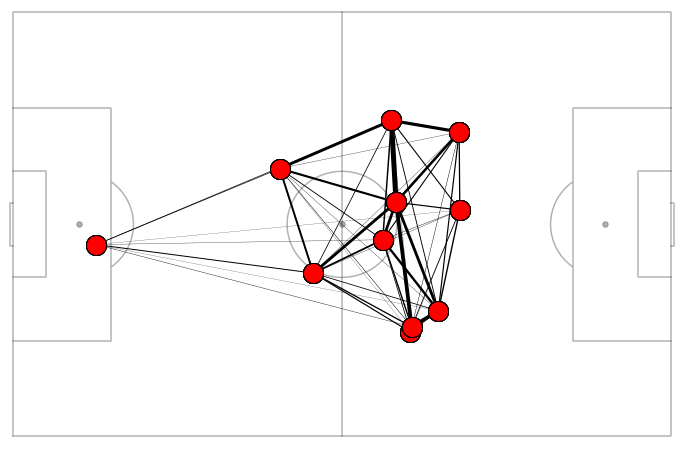

In [483]:
max_pair_count = df_total['total'].max()
max_edge_width = 5
min_edge_width = 0.1

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
for i,row in df_total.iterrows():
    p1 = row['player1']
    p2 = row['player2']
    loc = [[player_loc.loc[p1]['x'],player_loc.loc[p2]['x']],[player_loc.loc[p1]['y'],player_loc.loc[p2]['y']]]
    num_passes = row['total']
    # Plot nodes
    ax.plot(loc[0],loc[1],'.',markersize=40,c='r',mec='k',zorder=10)
    # Plot edges
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.plot(loc[0],loc[1],'k-',lw=line_width,zorder=9)

In [401]:
df_player[df_player.index.get_level_values('recipient') == players[0]]

player                  recipient            
Gerard Piqué Bernabéu   Marc-André ter Stegen    3
Samuel Yves Umtiti      Marc-André ter Stegen    4
Sergi Roberto Carnicer  Marc-André ter Stegen    2
dtype: int64